# COVID-19 and Temperature

As we approach the summer months, how might the rate of COVID-19 infections in humans increase or decrease? I aim to find a correlation between the infection rate and the temperature. To accomplish this, I will gather data about various US counties' monthly:

- Total number of infections
- Total number of deaths
- Average temperature
- Population Density

I wanted to drill in the data down to the county and month in order to leave out rooms for error such as the different temperatures per month and the varied temperatures between counties. This level of specificity should be fairly sufficient since counties generally have the same temperature due to small variations in latitude, longitude, and biomes between them. I also elected to choose the United States only because of the varied temperatures and biomes it has, and also the US had widespread testing insufficiencies. If I included other countries, that would skew the data.

USAFacts Google COVID Infections Dataset: https://console.cloud.google.com/marketplace/details/bigquery-public-datasets/covid19-dataset-list?filter=solution-type:dataset&filter=category:covid19&id=4a850823-3f83-48f5-92d1-01ba6f8ed81e

```SELECT * FROM `bigquery-public-data.covid19_usafacts.confirmed_cases```

```SELECT * FROM `bigquery-public-data.covid19_usafacts.deaths```

Wunderground weather: https://www.wunderground.com/history

Populations: https://api.census.gov/data/2019/pep/population?get=POP&for=county:*&in=state:*&key=

* Is this a reasonable task?

Originally, I had thought that merely aggregating daily average temperature data for various counties and obtaining the total number of infections corresponding to those temperatures. Then, I thought it would be good to input the temperature and output the infections to predict the number of infections based on the temperature; however, after plotting this data, it became apparent that the two were not correlated or linear. Thus, after consultation, I obtained advice make more use of the data by changing the scope of my project to take into account the population size in the form of a normalized data point, the transmission rate. After adjusting my project, I think this is a reasonable task.

* What are its input and output?

Its input will take in the sample average and variance and output the infection rate.


In [20]:
import pandas

covid_data = pandas.read_csv('./confirmed-usafacts.csv')

# Remove FIPS Code & January
covid_data.drop(covid_data.columns[3:14], axis=1, inplace=True)

# Remove May
covid_data.drop(covid_data.columns[93:], axis=1, inplace=True)

# Remove unneeded cities
covid_data.drop(covid_data.index[108:], inplace=True)

# Counties with no temperature data - remove
drop = [13,18,21,26,32,33,35,36,37,38,39,42,43,44,45,46,47,50,58,59,60,61,62,66,69,70,71,73,74,78,82,84,85,86,87,88,89,93,94,97,98,106]

for i in reversed(range(len(drop))):
    covid_data.drop(covid_data.index[drop[i]], inplace=True)

# Save
covid_data.to_csv('./covid-clean.csv')

In [39]:
# Accumulate infections for each temperature

infections = pandas.read_csv('./covid-clean.csv')
temperature = pandas.read_csv('./covid-temperature.csv')

temp_infections = {}

for i in range(0,65):
    for j in range(4,93):
        temp_infections[float(temperature.values[i][j])] = temp_infections.get(float(temperature.values[i][j]), 0) + float(infections.values[i][j])

In [40]:
import math

# Store values

df = pandas.DataFrame([[items[0], items[1]] for items in temp_infections.items() if not math.isnan(items[0])], columns=['temperature', 'infections'])

df.to_csv('temp-vs-infections.csv', index=False)

In [14]:
# Get populations

cc = pandas.read_csv('./covid-clean.csv')

p = []

for i in range(0, len(cc.values) - 1):
    for j in range(0, len(populations) - 1):
        if (str(cc.values[i][1]) == str(int((populations[j][1] + populations[j][2])))):
            p.append([cc.values[i][1], cc.values[i][2], populations[j][0]])

pop = pandas.read_csv('./covid-populations.csv')

for i in p:
    pop.loc[len(pop)] = i

pop.to_csv('./covid-populations.csv')


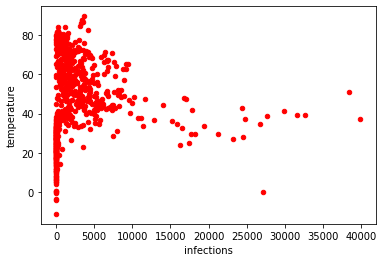

In [5]:
import matplotlib.pyplot as plt

df.plot(kind='scatter',x='infections',y='temperature',color='red')
plt.show()

In [24]:
import tensorflow as tf
import keras
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from keras.callbacks import LambdaCallback


Using TensorFlow backend.


In [41]:
data = pandas.read_csv('./temp-vs-infections.csv')

# print(data.values[:,:1])
print([row[0] for row in data.values])

print([row[1] for row in data.values])



[65.4, 60.4, 61.0, 53.9, 51.6, 55.0, 56.4, 59.2, 58.8, 56.3, 58.5, 57.3, 56.6, 57.6, 57.5, 59.3, 61.4, 61.3, 60.6, 61.8, 61.2, 59.9, 62.5, 65.8, 68.1, 67.3, 59.6, 59.0, 61.5, 61.6, 62.1, 61.9, 62.0, 65.3, 64.4, 61.7, 58.4, 59.4, 60.5, 62.4, 62.6, 56.8, 60.3, 62.3, 62.2, 60.7, 58.7, 59.5, 63.4, 65.9, 63.9, 62.7, 63.1, 64.3, 64.7, 67.1, 70.4, 68.8, 68.7, 68.2, 68.5, 68.0, 48.2, 50.4, 55.5, 66.2, 67.2, 42.8, 55.3, 68.4, 69.8, 67.9, 59.7, 47.0, 49.7, 50.9, 69.0, 63.8, 53.2, 43.3, 43.7, 52.0, 50.6, 42.1, 47.2, 56.1, 70.3, 64.2, 55.8, 51.2, 65.1, 65.5, 67.4, 69.3, 66.0, 66.6, 69.4, 73.1, 73.0, 64.0, 71.4, 72.7, 74.0, 72.0, 73.6, 75.7, 75.3, 70.5, 70.8, 75.6, 77.2, 63.3, 72.5, 71.2, 64.1, 67.8, 72.8, 69.6, 72.9, 66.8, 67.7, 38.9, 38.0, 46.0, 42.6, 40.8, 47.6, 36.8, 38.8, 44.3, 41.9, 41.7, 32.6, 23.7, 38.3, 43.2, 47.8, 46.1, 33.9, 28.8, 38.1, 45.6, 47.4, 47.1, 42.2, 36.7, 36.3, 48.8, 51.0, 46.7, 39.3, 40.4, 45.3, 54.7, 58.9, 51.7, 48.7, 51.1, 46.5, 42.9, 47.3, 48.5, 48.1, 58.0, 46.8, 44.6, 47.

In [45]:
temp_training = [row[0] for row in data.values]
temp_targets = [int(row[1]) for row in data.values]

In [50]:
lr = Sequential([
    Dense(1, input_shape=(1,), kernel_regularizer=keras.regularizers.l2(0.001)), # 1 layer
    Activation('linear'), # linear activation function
])

# We want to do plain vanilla stochastic gradient descent here, nothing fancy. 
# The call below removes all bells and whistles from the keras implementation of stochastic gradient
# descent. We will learn how to add back the momentum and Nesterov acceleration later.

opt = SGD(lr=0.01,momentum=0,nesterov=False)

# SGD & MSE

lr.compile(optimizer=opt, loss=keras.losses.hinge)
# 

# Again we initialize weights
lr.layers[0].set_weights([np.array([[0.01]]),np.array([0.0])])

In [51]:


lr.fit(temp_training, temp_targets, epochs=40, batch_size=10, shuffle=False)

Epoch 1/40
657/657 [==============================] - 0s 123us/step - loss: 0.1500
Epoch 2/40
657/657 [==============================] - 0s 68us/step - loss: 0.1492
Epoch 3/40
657/657 [==============================] - 0s 83us/step - loss: 0.1484
Epoch 4/40
657/657 [==============================] - 0s 67us/step - loss: 0.1484
Epoch 5/40
657/657 [==============================] - 0s 67us/step - loss: 0.1480
Epoch 6/40
657/657 [==============================] - 0s 67us/step - loss: 0.1476
Epoch 7/40
657/657 [==============================] - 0s 65us/step - loss: 0.1472
Epoch 8/40
657/657 [==============================] - 0s 71us/step - loss: 0.1468
Epoch 9/40
657/657 [==============================] - 0s 66us/step - loss: 0.1464
Epoch 10/40
657/657 [==============================] - 0s 77us/step - loss: 0.1460
Epoch 11/40
657/657 [==============================] - 0s 99us/step - loss: 0.1464
Epoch 12/40
657/657 [==============================] - 0s 113us/step - loss: 0.1453
Epoch 13/40

In [53]:
lr.predict([63])

array([[2.4878974]], dtype=float32)